## Import libraries

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs





In [2]:
# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.00025

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Load Data





In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers= 7, shuffle=True, drop_last=True, pin_memory=True)

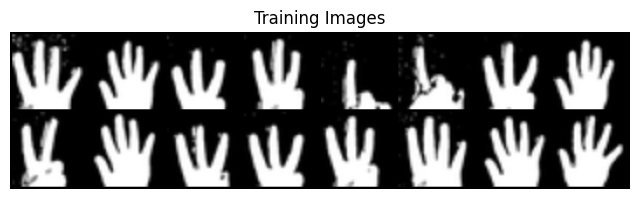

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## DCGAN model Implementation

### Weight Initialization


```
# This is formatted as code
```



In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Define Generator

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Define Discriminator


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions and Optimizers

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
noise_label = 0.85

# Optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

### Training


*   Step 1 - Train the Discriminator
*   Step 2 - Train the Generator


In [12]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


In [13]:
!pip install torchmetrics

In [14]:
# Training Loop
from torchmetrics.classification import BinaryAccuracy
metric = BinaryAccuracy().to(device)
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_accuracies = []
D_accuracies = []
iters = 0
G_loss_avg_list = []
D_loss_avg_list = []
G_acc_avg_list = []
D_acc_avg_list = []
c = 0.01 # clip (-c,c)
one= torch.FloatTensor([1]).to(device)
mone= one* -1

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        for p in netD.parameters():
            p.requires_grad = True
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        for p in netD.parameters():
            p.data.clamp_(-c,c)
            
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu)
        # Calculate loss on all-real batch
        # errD_real = criterion(output, label)
        errD_real = output.mean(0).view(1)
        
        # Calculate D's accuracy on all-fake batch
        preds_real = output > 0.5
        accD_real = metric(preds_real.view(-1),label)
        
        
        # Calculate gradients for D in backward pass
        errD_real.backward(one)
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = output.mean(0).view(1)
        # Calculate D's accuracy on all-fake batch
        preds_fake = output > 0.5
        accD_fake = metric(preds_fake,label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward(mone)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real - errD_fake
        # Update D
        optimizerD.step()
        # Compute acc for D
        accD = (accD_real + accD_fake) * 0.5
        
        for p in netD.parameters():
            p.requires_grad = False

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)#.view(-1)
        # Calculate G's loss based on this output
        errG = output.mean().mean(0).view(1)
        # Calculate D's accuracy on all-fake batch
        preds_G = output > 0.5
        accG = metric(preds_G.view(-1),label)
        
        # Calculate gradients for G
        errG.backward(one)
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Save Accuracy for plotthing later
        G_accuracies.append(accG.item())
        D_accuracies.append(accD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        '''
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        '''
            
        iters += 1
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    G_avg = sum(G_losses) / len(G_losses)
    G_loss_avg_list.append(G_avg)
    D_avg = sum(D_losses) / len(D_losses)
    D_loss_avg_list.append(D_avg)

    G_avg2 = sum(G_accuracies) / len(G_accuracies)
    G_acc_avg_list.append(G_avg2)
    D_avg2 = sum(D_accuracies) / len(D_accuracies)
    D_acc_avg_list.append(D_avg2)

2023-01-27 20:14:31.221692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 20:14:32.784287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64
2023-01-27 20:14:32.784403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64
2023-01-27 20:14:32.784415: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Starting Training Loop...
[0/150][0/62]	Loss_D: -0.0010	Loss_G: 0.5272	D(x): 0.4994	D(G(z)): 0.5004 / 0.5272
[0/150][20/62]	Loss_D: -0.0401	Loss_G: 0.5392	D(x): 0.4448	D(G(z)): 0.4849 / 0.5392
[0/150][40/62]	Loss_D: -0.0618	Loss_G: 0.6013	D(x): 0.4122	D(G(z)): 0.4739 / 0.6013
[0/150][60/62]	Loss_D: -0.0718	Loss_G: 0.5470	D(x): 0.5101	D(G(z)): 0.5818 / 0.5470
[1/150][0/62]	Loss_D: -0.1169	Loss_G: 0.5925	D(x): 0.4550	D(G(z)): 0.5719 / 0.5925
[1/150][20/62]	Loss_D: -0.0830	Loss_G: 0.5430	D(x): 0.5158	D(G(z)): 0.5988 / 0.5430
[1/150][40/62]	Loss_D: -0.0953	Loss_G: 0.6011	D(x): 0.4891	D(G(z)): 0.5844 / 0.6011
[1/150][60/62]	Loss_D: -0.0421	Loss_G: 0.6065	D(x): 0.4642	D(G(z)): 0.5063 / 0.6065
[2/150][0/62]	Loss_D: -0.0665	Loss_G: 0.5708	D(x): 0.4368	D(G(z)): 0.5033 / 0.5708
[2/150][20/62]	Loss_D: -0.0876	Loss_G: 0.5743	D(x): 0.4370	D(G(z)): 0.5246 / 0.5743
[2/150][40/62]	Loss_D: -0.0566	Loss_G: 0.5382	D(x): 0.4898	D(G(z)): 0.5464 / 0.5382
[2/150][60/62]	Loss_D: -0.0692	Loss_G: 0.4931	D(x): 0

## Results

**Loss versus training iteration**


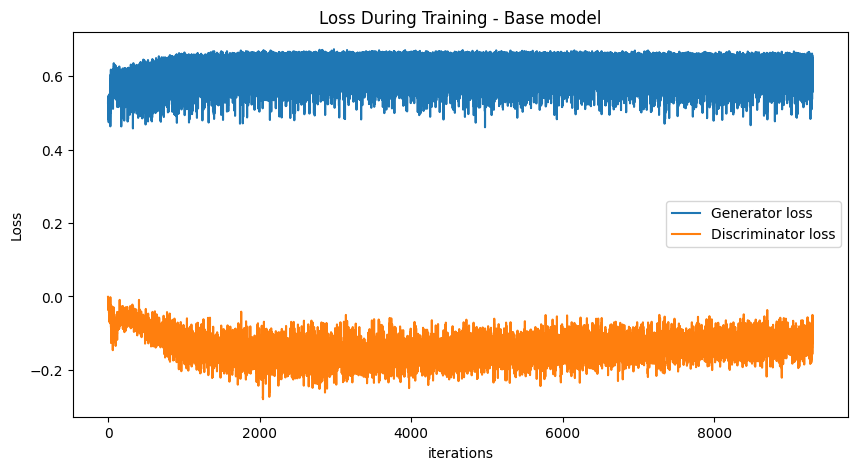

In [15]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Base model")
plt.plot(G_losses,label="Generator loss")
plt.plot(D_losses,label="Discriminator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_base_iteration.png')
plt.show()

**Loss versus training epochs**

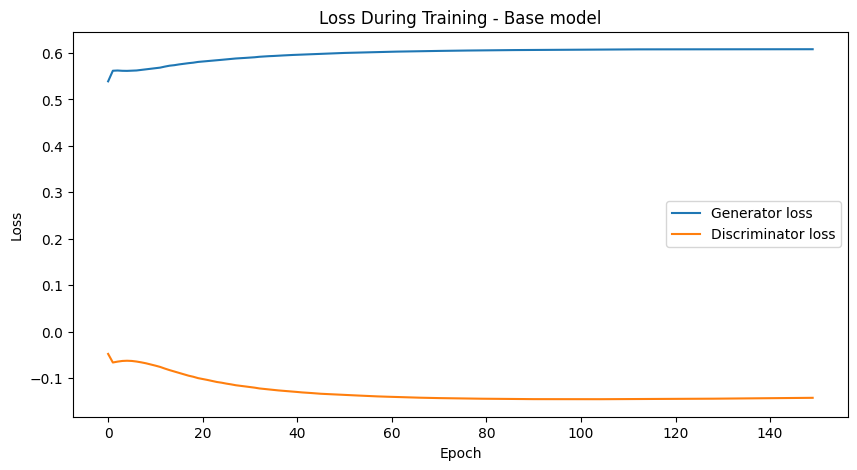

In [16]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training - Base model")
plt.plot(G_loss_avg_list,label="Generator loss")
plt.plot(D_loss_avg_list,label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_base_epoch.png')
plt.show()

**Accuracy versus training iterations**

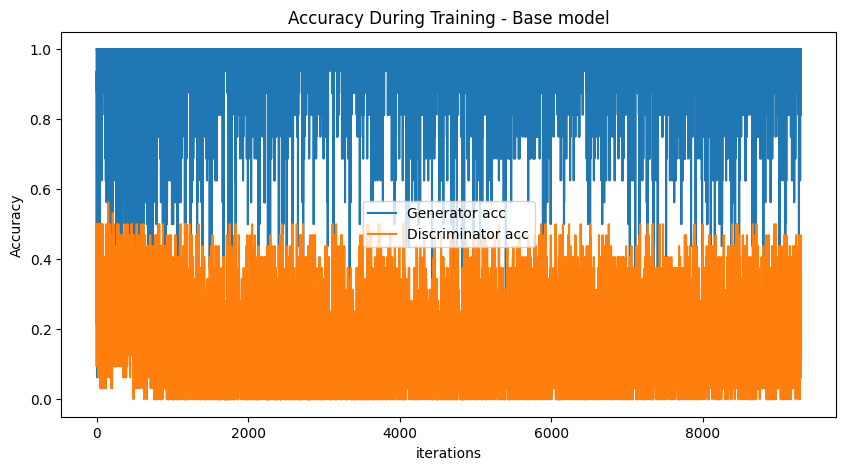

In [17]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Base model")
plt.plot(G_accuracies,label="Generator acc")
plt.plot(D_accuracies,label="Discriminator acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_base_iteration.png')
plt.show()

**Accuracy versus training epochs**

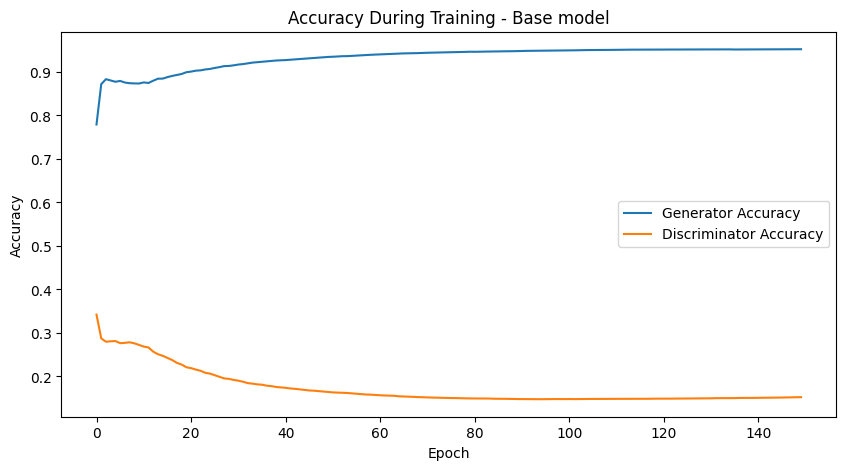

In [18]:
plt.figure(figsize=(10,5))
plt.title("Accuracy During Training - Base model")
plt.plot(G_acc_avg_list,label="Generator Accuracy")
plt.plot(D_acc_avg_list,label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_base_epoch.png')
plt.show()